# 06. PyOD Algorithms Comparison

Compare anomaly detection algorithms using PyOD library:
- **IForest** - Isolation Forest (tree-based, recommended)
- **ECOD** - Empirical Cumulative Distribution (parameter-free)

**Note:** LOF is only available at aggregated level via `AggregatedPyOD` (O(n²) - too slow for 13M tenders).

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.data_loader import load_tenders, load_buyers, load_suppliers, load_bids
from src.detectors import PyODDetector, compare_algorithms

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Started: 2026-02-07 19:41:04


## 1. Load Data

In [2]:
tenders = load_tenders(years=[2022, 2023, 2024, 2025])  # Full dataset
buyers = load_buyers()
suppliers = load_suppliers()

print(f"Tenders: {len(tenders):,}")
print(f"Buyers: {len(buyers):,}")
print(f"Suppliers: {len(suppliers):,}")

Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Loaded 12,877,960 records
Loaded buyers: 35,995
Loaded suppliers: 358,376
Tenders: 12,877,960
Buyers: 35,995
Suppliers: 358,376


## 2. Compare Algorithms

In [3]:
# Compare IForest and ECOD (main algorithms)
comparison = compare_algorithms(
    tenders,
    algorithms=["iforest", "ecod"],
    contamination=0.05,
    buyers_df=buyers,
    suppliers_df=suppliers,
)

print("\n" + "="*60)
print("COMPARISON RESULTS")
print("="*60)
display(comparison)


PyOD Detector: IFOREST
  Isolation Forest - isolates anomalies using random trees
Processing 12,877,960 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (12877960, 14)
Step 3/3: Fitting IFOREST...

IFOREST complete!
  Anomalies: 643,898 (5.00%)

PyOD Detector: ECOD
  Empirical Cumulative Distribution - unsupervised, parameter-free
Processing 12,877,960 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (12877960, 14)
Step 3/3: Fitting ECOD...


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of  14 | elapsed:    5.4s remaining:   33.1s
[Parallel(n_jobs=14)]: Done  14 out of  14 | elapsed:    8.7s finished



ECOD complete!
  Anomalies: 643,898 (5.00%)

COMPARISON RESULTS


,algorithm,anomalies,anomaly_rate,mean_score,max_score
0,iforest,643898,5.0,0.175640,1.0
1,ecod,643898,5.0,0.118809,1.0


## 3. Visualize Comparison

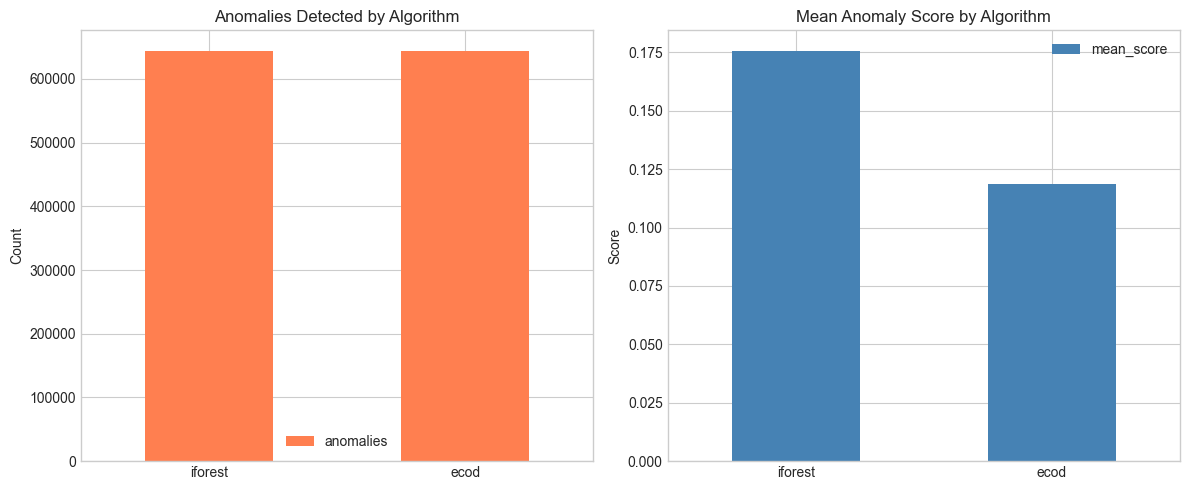

In [4]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Anomaly count
ax1 = axes[0]
comparison.plot(kind='bar', x='algorithm', y='anomalies', ax=ax1, color='coral')
ax1.set_title('Anomalies Detected by Algorithm')
ax1.set_xlabel('')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Mean score
ax2 = axes[1]
comparison.plot(kind='bar', x='algorithm', y='mean_score', ax=ax2, color='steelblue')
ax2.set_title('Mean Anomaly Score by Algorithm')
ax2.set_xlabel('')
ax2.set_ylabel('Score')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../results/pyod_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Detailed Analysis with Best Algorithm

In [5]:
# Use Isolation Forest (usually best for tabular data)
detector = PyODDetector(
    algorithm="iforest",
    contamination=0.05,
    random_state=42,
)

results = detector.fit_detect(
    tenders,
    buyers_df=buyers,
    suppliers_df=suppliers,
)

print("\nSummary:")
display(detector.summary())

PyOD Detector: IFOREST
  Isolation Forest - isolates anomalies using random trees
Processing 12,877,960 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (12877960, 14)
Step 3/3: Fitting IFOREST...

IFOREST complete!
  Anomalies: 643,898 (5.00%)

Summary:


,metric,value
0,algorithm,iforest
1,total_tenders,12877960
2,anomalies,643898
3,anomaly_rate,5.0
4,risk_critical,4018
5,risk_high,102727
6,risk_medium,776380
7,risk_low,11994834


In [6]:
# Risk level distribution
print("Risk Level Distribution:")
print(results['risk_level'].value_counts().sort_index())

Risk Level Distribution:
risk_level
low         11994834
medium        776380
high          102727
critical        4018
Name: count, dtype: int64


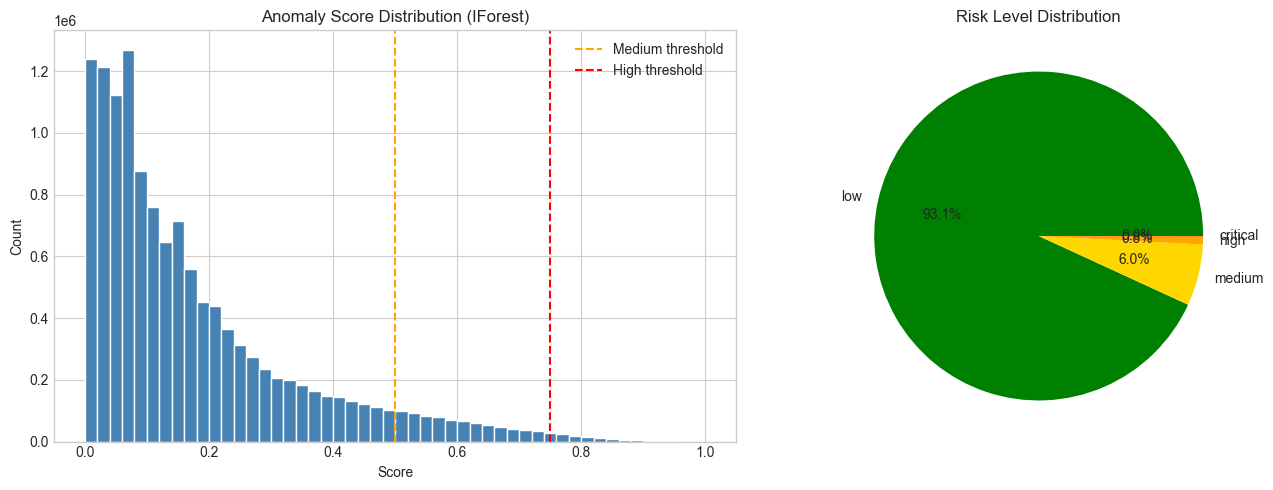

In [7]:
# Score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
results['score'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='white')
ax1.axvline(x=0.5, color='orange', linestyle='--', label='Medium threshold')
ax1.axvline(x=0.75, color='red', linestyle='--', label='High threshold')
ax1.set_title('Anomaly Score Distribution (IForest)')
ax1.set_xlabel('Score')
ax1.set_ylabel('Count')
ax1.legend()

# Risk level pie
ax2 = axes[1]
risk_counts = results['risk_level'].value_counts()
colors = {'low': 'green', 'medium': 'gold', 'high': 'orange', 'critical': 'red'}
risk_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                 colors=[colors.get(x, 'gray') for x in risk_counts.index])
ax2.set_title('Risk Level Distribution')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('../results/pyod_iforest_scores.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. High-Risk Tenders Analysis

In [8]:
# Get high-risk anomalies
high_risk = detector.get_anomalies(min_score=0.75)
print(f"High-risk tenders (score >= 0.75): {len(high_risk):,}")

# Merge with tender details
high_risk_details = high_risk.merge(
    tenders[['tender_id', 'tender_value', 'procurement_method', 'is_single_bidder', 'price_change_pct']],
    on='tender_id'
)

print(f"\nTotal value: {high_risk_details['tender_value'].sum()/1e9:.2f} B UAH")
print(f"Single bidder rate: {high_risk_details['is_single_bidder'].mean()*100:.1f}%")
print(f"\nTop 10 by score:")
display(high_risk_details.nlargest(10, 'score')[['tender_id', 'score', 'risk_level', 'tender_value', 'procurement_method', 'is_single_bidder']])

High-risk tenders (score >= 0.75): 106,745

Total value: 469.10 B UAH
Single bidder rate: 21.2%

Top 10 by score:


,tender_id,score,risk_level,tender_value,procurement_method,is_single_bidder
72645,a64bd9a948ad412099e0cb527fe16254,1.000000,critical,2.909990e+06,open,0
106165,36affc1427974edcb1ca16dd1fd81aaa,0.998812,critical,1.200000e+05,open,0
56545,caefaa8c92ee449db372d9dc014114b3,0.998140,critical,2.800000e+04,selective,0
46645,9c4f38cd799f4a849cac5271b4b541b3,0.997624,critical,3.750000e+07,selective,0
57858,7868e909cc754e33a57a4d0dbfad7fab,0.997624,critical,3.750000e+07,selective,0
94303,6a15163c5c204df891d1ad92462c274b,0.996437,critical,1.630215e+05,selective,0
90853,671a0592c2684d2383f265b806580955,0.995252,critical,1.749500e+05,open,0
31585,3830ad17464a4b8087d72680de7158ba,0.991699,critical,5.150000e+07,selective,0
29522,547d00275eb74b7ca95656c34e790551,0.991453,critical,1.900000e+08,selective,0
88943,b5e42f6aa280479dab9eab36db26d9db,0.991453,critical,6.709922e+04,open,0


In [9]:
# Procurement method distribution in anomalies
print("Procurement method in high-risk tenders:")
print(high_risk_details['procurement_method'].value_counts(normalize=True).mul(100).round(1))

Procurement method in high-risk tenders:
procurement_method
open         54.5
selective    41.4
limited       4.1
Name: proportion, dtype: float64


## 6. Algorithm Agreement Analysis

In [10]:
# Run both algorithms and check overlap
algorithms_to_compare = ["iforest", "ecod"]
all_results = {}

for algo in algorithms_to_compare:
    print()
    print("=" * 60)
    det = PyODDetector(algorithm=algo, contamination=0.05)
    res = det.fit_detect(tenders, buyers_df=buyers, suppliers_df=suppliers)
    all_results[algo] = set(res[res["anomaly"] == 1]["tender_id"].tolist())


PyOD Detector: IFOREST
  Isolation Forest - isolates anomalies using random trees
Processing 12,877,960 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (12877960, 14)
Step 3/3: Fitting IFOREST...

IFOREST complete!
  Anomalies: 643,898 (5.00%)

PyOD Detector: ECOD
  Empirical Cumulative Distribution - unsupervised, parameter-free
Processing 12,877,960 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (12877960, 14)
Step 3/3: Fitting ECOD...


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of  14 | elapsed:    3.4s remaining:   21.0s
[Parallel(n_jobs=14)]: Done  14 out of  14 | elapsed:    6.5s finished



ECOD complete!
  Anomalies: 643,898 (5.00%)


In [11]:
# Calculate overlap
from itertools import combinations

print("\nPairwise Agreement (Jaccard similarity):")
print("="*50)

for algo1, algo2 in combinations(algorithms_to_compare, 2):
    set1 = all_results[algo1]
    set2 = all_results[algo2]
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    jaccard = intersection / union if union > 0 else 0
    print(f"{algo1:8} vs {algo2:8}: {jaccard:.3f} ({intersection:,} common anomalies)")


Pairwise Agreement (Jaccard similarity):
iforest  vs ecod    : 0.712 (535,538 common anomalies)


In [12]:
# Consensus anomalies (flagged by both algorithms)
from collections import Counter

all_anomalies = []
for algo, ids in all_results.items():
    all_anomalies.extend(ids)

anomaly_counts = Counter(all_anomalies)
consensus_both = [tid for tid, count in anomaly_counts.items() if count == len(algorithms_to_compare)]

print(f"\nConsensus Analysis:")
print(f"  Flagged by BOTH algorithms: {len(consensus_both):,}")


Consensus Analysis:
  Flagged by BOTH algorithms: 535,538


In [13]:
# Analyze consensus anomalies
if consensus_both:
    consensus_df = tenders[tenders['tender_id'].isin(consensus_both)].copy()
    print(f"\nConsensus anomalies (flagged by both algorithms):")
    print(f"  Count: {len(consensus_df):,}")
    print(f"  Total value: {consensus_df['tender_value'].sum()/1e9:.2f} B UAH")
    print(f"  Single bidder rate: {consensus_df['is_single_bidder'].mean()*100:.1f}%")
    print(f"\n  Procurement methods:")
    print(consensus_df['procurement_method'].value_counts())


Consensus anomalies (flagged by both algorithms):
  Count: 535,538
  Total value: 1557.81 B UAH
  Single bidder rate: 30.9%

  Procurement methods:
procurement_method
open         271016
selective    186938
limited       77584
Name: count, dtype: int64


## 7. Save Results

In [14]:
# Save comparison results
comparison.to_csv('../results/pyod_algorithm_comparison.csv', index=False)

# Save high-risk anomalies
high_risk_details.to_csv('../results/pyod_high_risk_tenders.csv', index=False)

# Save consensus anomalies
if consensus_both:
    pd.DataFrame({'tender_id': consensus_both}).to_csv('../results/pyod_consensus_anomalies.csv', index=False)

print("Results saved to ../results/")
print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Results saved to ../results/

Completed: 2026-02-07 19:49:15
